Step 1: Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Step 2: Load the Dataset

In [ ]:
import pandas as pd

# Load event sequences and labels
event_traces = pd.read_csv('/content/drive/MyDrive/Dataset-ThreatSlayers/Event_traces.csv', header=None)
labels = pd.read_csv('/content/drive/MyDrive/Dataset-ThreatSlayers/anomaly_label.csv', header=None)

print("Shape of event_traces:", event_traces.shape)
print("Shape of labels:", labels.shape)

/tmp/ipython-input-2176689438.py:4: DtypeWarning: Columns (2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  event_traces = pd.read_csv('/content/drive/MyDrive/Dataset-ThreatSlayers/Event_traces.csv', header=None)


Shape of event_traces: (575062, 6)
Shape of labels: (575062, 2)


Step 3: Cleaned Code (Start from Loaded Data)

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 3: Clean and preprocess event traces and labels

# 3.1: Fill missing values and convert to strings
event_traces = event_traces.fillna('MISSING').astype(str)

# 3.2: Label encode each column individually
event_traces_encoded = event_traces.apply(lambda col: LabelEncoder().fit_transform(col))

# 3.3: Convert encoded dataframe to list of sequences and pad
sequences = event_traces_encoded.values.tolist()
padded_sequences = pad_sequences(sequences, padding='post')
X_full = np.array(padded_sequences)

# --- Debugging labels ---

print("First 10 label values:")
print(labels.iloc[:10, 1].tolist())

print("\nUnique label values:")
print(labels.iloc[:, 1].unique())

# 3.4: Clean labels - convert to string and strip spaces
labels_str = labels.iloc[:, 1].astype(str).str.strip()

# Remove header row if present
if labels_str.iloc[0] == 'Label' or labels_str.iloc[0] not in ['Normal', 'Anomaly', '0', '1']:
    labels_str = labels_str[1:].reset_index(drop=True)
    X_full = X_full[1:]

# 3.5: Map string labels to numeric values
label_map = {'Normal': 0, 'Anomaly': 1, '0': 0, '1': 1}
labels_mapped = labels_str.map(label_map)

print("\nMapped labels sample:")
print(labels_mapped.head(10))

print("\nCount valid numeric labels:", labels_mapped.notna().sum())
print("Count invalid labels (NaN):", labels_mapped.isna().sum())

# 3.6: Filter valid labels and align X and y
valid_mask = labels_mapped.notna()
X = X_full[valid_mask.values]
y = labels_mapped[valid_mask].astype('float32').values

print("\n✅ Data cleaned and ready!")
print("X shape:", X.shape)
print("y shape:", y.shape)

First 10 label values:
['Label', 'Normal', 'Normal', 'Anomaly', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal']

Unique label values:
['Label' 'Normal' 'Anomaly']

Mapped labels sample:
0    0
1    0
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 1, dtype: int64

Count valid numeric labels: 575061
Count invalid labels (NaN): 0

✅ Data cleaned and ready!
X shape: (575061, 6)
y shape: (575061,)


Step 4: Build the LSTM autoencoder Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Embedding

# Define model parameters
timesteps = X.shape[1]            # sequence length
input_dim = int(X.max()) + 1      # vocabulary size

inputs = Input(shape=(timesteps,))
x = Embedding(input_dim=input_dim, output_dim=64, mask_zero=True)(inputs)

# Change here: disable cuDNN by use_cudnn=False
encoded = LSTM(32, use_cudnn=False)(x)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, return_sequences=True, use_cudnn=False)(decoded)
decoded = TimeDistributed(Dense(1))(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 6, 64)     │ 36,803,968 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 6)         │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     12,416 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 6, 32)     │          0 │ lstm[0][0]        │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 6, 64)     │     24,832 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 6, 1)      │         65 │ lstm_1[0][0]      │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,841,281 (140.54 MB)

 Trainable params: 36,841,281 (140.54 MB)

 Non-trainable params: 0 (0.00 B)

Step 5: Train the LSTM Autoencoder

In [ ]:
# Train the model
history = autoencoder.fit(
    X,               # Input sequences
    X[..., None],    # Targets are the input sequences themselves, reshaped for TimeDistributed
    epochs=20,
    batch_size=64,
    validation_split=0.2
)

# ✅ Save the trained model to a file
autoencoder.save("lstm_autoencoder.h5")
print("✅ Model saved as lstm_autoencoder.h5")

# ✅ Download the saved model to your local computer
from google.colab import files
files.download("lstm_autoencoder.h5")


Epoch 1/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 31615918080.0000 - val_loss: 32023965696.0000
Epoch 2/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 132s 10ms/step - loss: 31390373888.0000 - val_loss: 31946397696.0000
Epoch 3/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 31439462400.0000 - val_loss: 31869296640.0000
Epoch 4/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - loss: 31318484992.0000 - val_loss: 31792463872.0000
Epoch 5/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 73s 10ms/step - loss: 31316051968.0000 - val_loss: 31716032512.0000
Epoch 6/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 31211442176.0000 - val_loss: 31639947264.0000
Epoch 7/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 83s 10ms/step - loss: 31128684544.0000 - val_loss: 31564335104.0000
Epoch 8/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - loss: 31042062336.0000 - val_loss: 31488970752.0000
Epoch 9/20
7189/7189 ━━━━━━━━━━━━━━━━━━━━ 72s 10ms/step - loss: 31004282880.0000 - val_loss: 31413946368.0000
Epoch 10/

✅ Model saved as lstm_autoencoder.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Step 6 :Plot the training loss curve

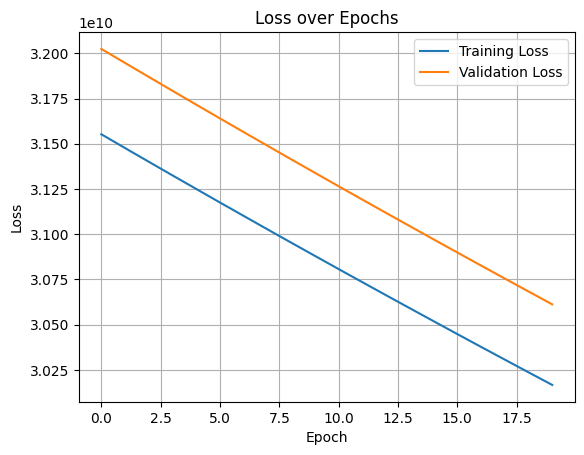

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Step 7: Use the autoencoder to reconstruct sequences

In [ ]:
X_pred = autoencoder.predict(X)

17971/17971 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step


Step 8: Calculate reconstruction error

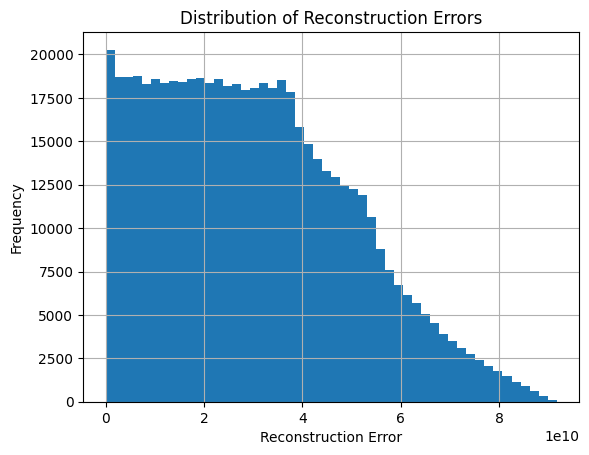

In [ ]:
X_flat = X.reshape(X.shape[0], -1)
X_pred_flat = X_pred.reshape(X_pred.shape[0], -1)

reconstruction_errors = np.mean(np.square(X_flat - X_pred_flat), axis=1)

# Optional: visualize distribution of reconstruction errors
import matplotlib.pyplot as plt

plt.hist(reconstruction_errors, bins=50)
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

Step 9 : Set a threshold for anomaly detection

In [ ]:
threshold = np.percentile(reconstruction_errors, 95)  # top 5% most unusual
print("Anomaly threshold:", threshold)

Anomaly threshold: 65942685435.15461


Step 10 : Detect anomalies

In [ ]:
anomalies = reconstruction_errors > threshold
print("Detected anomalies:", np.sum(anomalies))

Detected anomalies: 28753


Step 11: Evaluate Model with Classification Metrics

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.95      0.96    558223
     Anomaly       0.08      0.13      0.10     16838

    accuracy                           0.93    575061
   macro avg       0.52      0.54      0.53    575061
weighted avg       0.95      0.93      0.94    575061


Accuracy: 92.83%


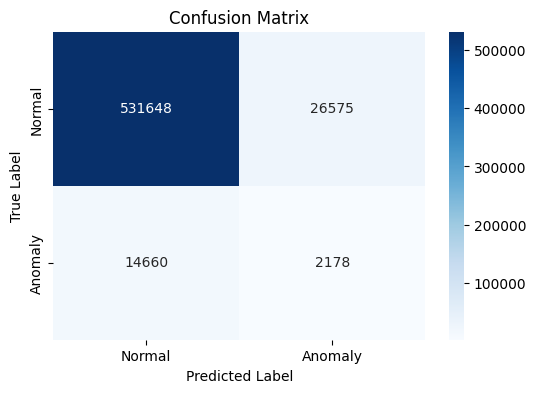

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Convert anomalies (detected from reconstruction error) to binary predictions
y_pred = anomalies.astype(int)

# Ensure ground truth labels (y) are integers
y_true = y.astype(int)

# Print basic classification metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))

# Print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

# Show confusion matrix
cm = confusion_matrix(y_true, y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Step 12 : Connect to API (Back end_Render)




Save model